In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 

import mne

%matplotlib widget

!date -I

2024-02-29


Ahoj Katko - zkus prosimte si trochu pohrat s tim prahovanim - mozna bude davat smysl globalni normalizace, misto po jednotlivych ROI. V podstate jde o to, aby pred stimulaci nebyla zadna signifikantni aktivace a odpoved po stimulaci byla co nejcistsi. Viz procedura v klasickem PCI (https://doi.org/10.1126/scitranslmed.3006294), maji to popsane v appendixu. Neni treba vymyslet robustni algoritmus, spis inspirace pro rucni volbu prahu. 
- nebudu teď zkoušet, protože to vypadá, že po opravě baseline correction to už je hezké, před stimulací srovnané a po ní reakce

Co by mi taky davalo smysl je si ROI seradit v carpet plotu podle jednotlich komunikacnich metrik aplikovanych na SC a pak se podivat jestli ty odezvy (at uz simulovane nebo empiricke) tohle razeni v nejake forme nerespektuji (napr. prvni peak, nebo nejvetsi peak, ....).
- kouknout od oka na notebook od Honzy, ale mám to níže jako barcody a moc to nevypadá
- koukala jsem na to v notebooku od Honzy a nemám pocit, že by to někam moc vedlo

Co zkouším a jak to jde

- našla jsem si chybu v baseline correction
    - https://mne.tools/stable/generated/mne.baseline.rescale.html
    - můžu použít mode='zscore'
        - inspirace: "First, each source’s activity was centralized and normalized on the mean and standard deviation of its baseline level (from -500 to -1 ms)." [A Theoretically Based Index of Consciousness Independent of Sensory Processing and Behavior, Supplementary Material] (*ten popis, jak to dělali, pokračuje dalšími kroky, které bych taky mohla zkusit*)    
- hezčí notebook, aby to tu bylo všechno vidět - no, nějak...

článek s modularitou

- usekávají response v nule?
- našli korelaci se strukturní konektivitou

nápady

- globální normalizace
- korelace s průměrem odpovědi, se std odchylkou odpovědi
    - zkusila jsem, nefuguje, navíc průměr nedává moc smysl
- PCA před tím vším - čistší data?
    - nějak to tak dělají v článku A Theoretically Based Index of Consciousness...
- A Theoretically Based Index of Consciousness... - pokračovat v postupu, který popisují

z konzultace 19. 2.

- zkusit se simulovanými daty
    - zkouším, nepomáhá
- zkusit def. odpovědi jako v článku s modularitou
    - done (estimate AUC, sklearn AUC)
- kouknout na notebook od Honzy
    - done, a zkusila jsem to různě řadit, nic tam nevidím

co jsem ještě dělala
 
- seřazení ROI a ED/SC_W/SC_L
    - myslím, že je to ok, udělala jsem si obrázek mozku a tam sedí ty euklidovské vzdálenosti
- přečíst o strukturní konektivitě: <https://elifesciences.org/articles/83232#sa2>
    - narazila jsem na the Global Mean Field Power (GMFP), je to measure to characterize global EEG activity (<https://www.fieldtriptoolbox.org/tutorial/tms-eeg/>)

co zkusit

- zamyslet se, jak využít modularitu, která má celkově nějakou korelaci s TMS response, https://www.sciencedirect.com/science/article/pii/S1053811920311836, když chci predikce na ROI levelu
    - pro každý vrchol určím, ve které je skupině (limbic, visual, default, ...)
    - TODO co dál, nějak pracovat s tím, kolik hran uvnitř a kolik vně skupiny
    - možná inspirace? <https://ieeexplore.ieee.org/abstract/document/9314244>
- co zkusit: zkontrolovat, že empirical a simulated je správně připraveno (viz source reconstructed time series extraction notebook)
- použít pro strukturní konektivitu jiná data, kde nebude tolik bílých míst

In [2]:
def plot_data(data,title=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data);
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,labels,title=None,constants=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants:
        plt.plot([c]*400)
    plt.title(labels[roi_id])
    plt.show()

## Load data

### Load pytepfit data

In [3]:
data_pytepfit = np.load('../data/external/pytepfit/source_estimates/empirical.npz')
data_pytepfit['ts'].shape

(400, 200)

In [4]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [5]:
data_pytepfit['labels'].shape

(200,)

In [6]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

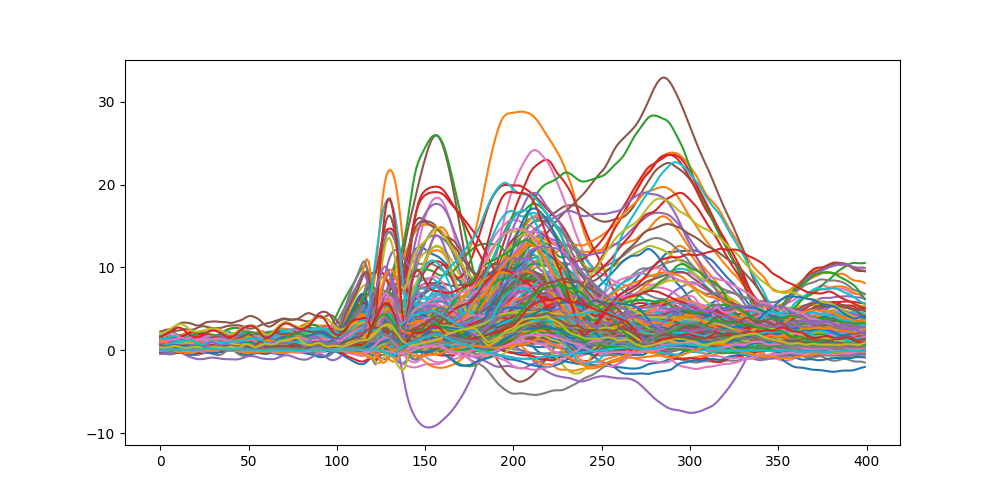

In [7]:
plot_data(data_pytepfit['ts'])

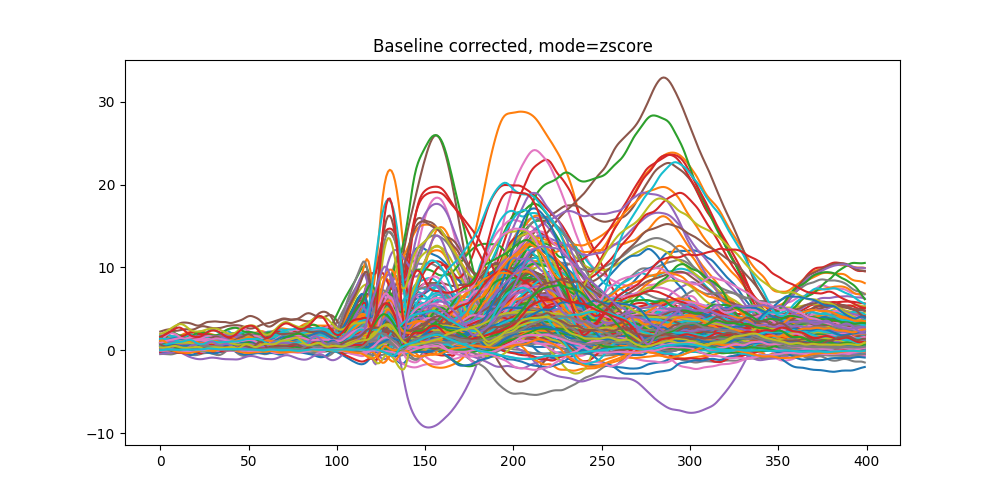

In [8]:
baseline_correction_mode = 'zscore'
# corrected = mne.baseline.rescale(data_pytepfit['ts'].T, np.array([i for i in range(400)]), (0,99), mode=baseline_correction_mode).T
corrected = data_pytepfit['ts']


plot_data(corrected,title=f'Baseline corrected, mode={baseline_correction_mode}')

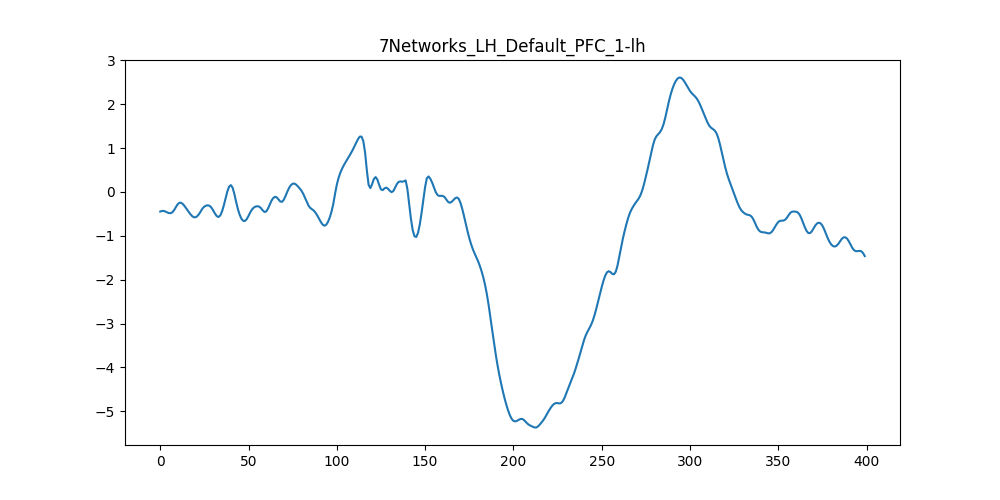

In [9]:
plot_one_roi(corrected,17,data_pytepfit['labels'])

In [10]:
def get_amplitude_first_peak(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold or val < -threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    while id_above_threshold < len(seqence) and (seqence[id_above_threshold] > threshold or seqence[id_above_threshold] < -threshold): 
        if seqence[id_above_threshold] > abs(max_value_above_threshold):
            max_value_above_threshold = abs(seqence[id_above_threshold])
        id_above_threshold += 1
    
    return max_value_above_threshold

def get_amplitude_first_peak_id(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold or val < -threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    max_value_above_threshold_id = id_above_threshold
    
    while id_above_threshold < len(seqence) and (seqence[id_above_threshold] > threshold or seqence[id_above_threshold] < -threshold): 
        if seqence[id_above_threshold] > abs(max_value_above_threshold):
            max_value_above_threshold = abs(seqence[id_above_threshold])
            max_value_above_threshold_id = id_above_threshold
        id_above_threshold += 1
    
    return max_value_above_threshold_id

def get_amplitude_highest_peak(seqence, threshold):
    val = seqence[np.argmax(np.abs(seqence))]

    if val > threshold or val < -threshold:
        return abs(val)
    return None

def get_amplitude_highest_peak_id(seqence, threshold):
    argmax = np.argmax(np.abs(seqence))
    val = seqence[argmax]

    if val > threshold or val < -threshold:
        return argmax
    return None

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if abs(v) > threshold:
            estimate += abs(v)

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(corrected_data,stim_idx):
    # TODO předělat upper, protože takhle poslední dvě hodnoty nedávají smysl?
    maxima = np.max(corrected[stim_idx:,:],axis=0)
    maxima.sort()

    upper = int(maxima[-5])
    lower = int(np.max(corrected_data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

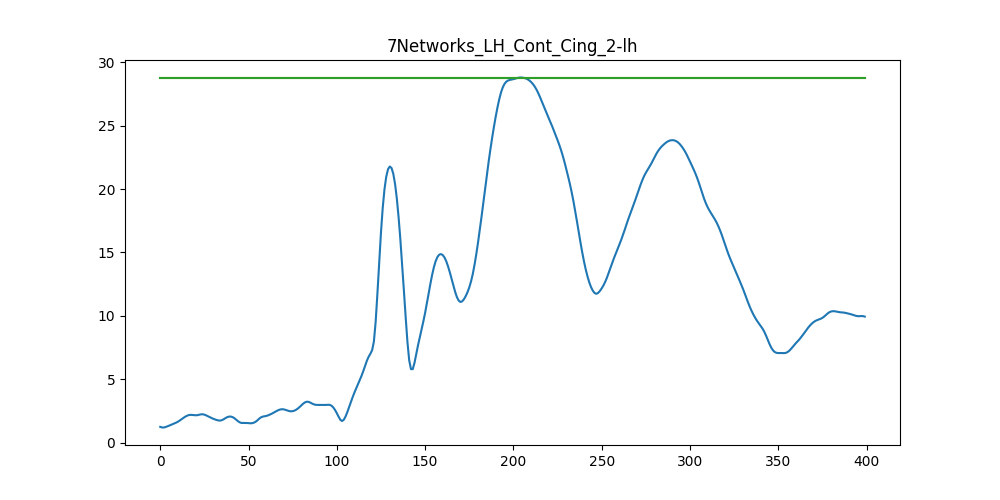

In [11]:
roi_idx = 1

amp = get_amplitude_first_peak(corrected[:,roi_idx],threshold=5)
amp_h = get_amplitude_highest_peak(corrected[:,roi_idx],threshold=5)

plot_one_roi(corrected,roi_idx,labels=data_pytepfit['labels'],constants=[amp,amp_h])

In [12]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(corrected,stim_time)

from sklearn import metrics as sk_metrics
# sklearn.metrics.auc(x, y)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200), columns=['01-response','amp_highest','amp_first'])

    maxima = np.max(corrected,axis=0)
    response_df['01-response'] = maxima > threshold
    response_df['amp_first'] = np.array([get_amplitude_first_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_first_id'] = np.array([get_amplitude_first_peak_id(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_highest'] = np.array([get_amplitude_highest_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_highest_id'] = np.array([get_amplitude_highest_peak_id(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['variance'] = np.var(corrected[stim_time:],axis=0)
    response_df['variance_ot'] = np.where(response_df['01-response'],response_df['variance'],None)
    response_df['diff'] = np.max(corrected[stim_time:],axis=0)-np.min(corrected[stim_time:],axis=0)
    response_df['diff_ot'] = np.where(response_df['01-response'],response_df['diff'],None)
    response_df['AUC_estimate'] = np.array([estimate_auc(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['AUC_sklearn'] = np.array([sk_metrics.auc(list(range(len(corrected[stim_time:,i]))), abs(corrected[stim_time:,i])) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(corrected[stim_time:,i]) for i in range(200)],dtype=float)

    responses[threshold] = response_df

In [13]:
def prepare_barcode(n_rows,n_cols,title=None):
    pixel_per_bar = 4
    dpi = 100

    fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, tight_layout=True,sharex=True)
    fig.suptitle(title)
    return fig, ax

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1)
    else:
        code = data.reshape(1,-1)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(f"  {title}", loc="right", y=0, ha="left", va="center")
    ax.set_yticks([])

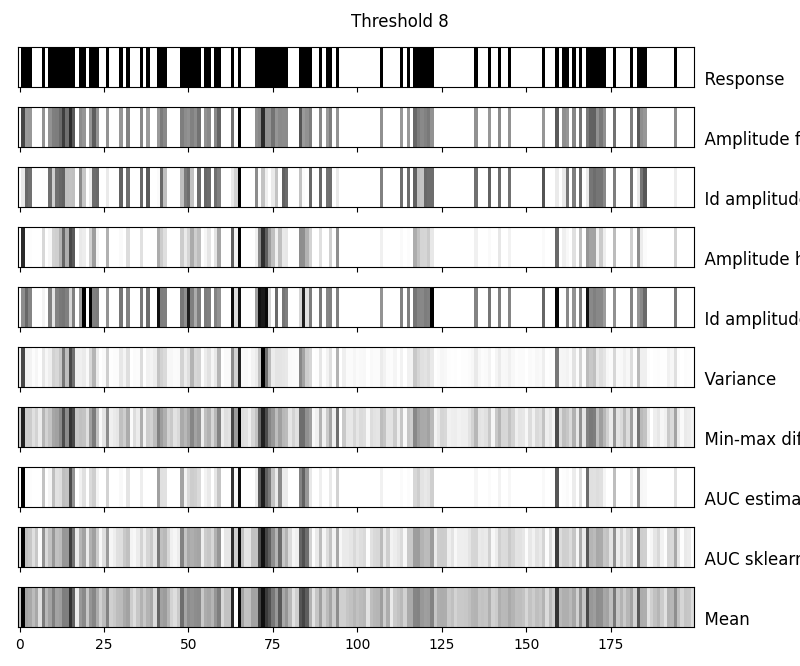

In [14]:
thr = list(responses.keys())[2]

fig, axs = prepare_barcode(10,200,title=f"Threshold {thr}")

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude first")
plot_one_barcode(axs[2],responses[thr]['amp_first_id'],title=f"Id amplitude first")
plot_one_barcode(axs[3],responses[thr]['amp_highest'],title=f"Amplitude highest")
plot_one_barcode(axs[4],responses[thr]['amp_highest_id'],title=f"Id amplitude highest")
plot_one_barcode(axs[5],responses[thr]['variance'],title=f"Variance")
plot_one_barcode(axs[6],responses[thr]['diff'],title=f"Min-max difference ")
plot_one_barcode(axs[7],responses[thr]['AUC_estimate'],title=f"AUC estimate")
plot_one_barcode(axs[8],responses[thr]['AUC_sklearn'],title=f"AUC sklearn")
plot_one_barcode(axs[9],responses[thr]['mean'],title=f"Mean")

z obrázků výše je vidět, že mezi těmi věcmi jsou korelace navzájem (místy asi fakt silné) - ty věci jsou "skoro stejné", je jedno, kterou z nich použiji, když tam korelace s ED nebo něčím jiným není, tak tam prostě není

In [15]:
stim_locatin = data_pytepfit['stim_location']

### Load structural (and functional) connectivity data

ne domhof, ty parcelace jsou jiné

In [16]:
SC_W, SC_L, FC = data.load_pytepfit_sc()

SC_L = np.where(SC_W == 0,np.nan,SC_L)

/tmp/ipykernel_86744/3017092137.py:4: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(SC_W))


Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

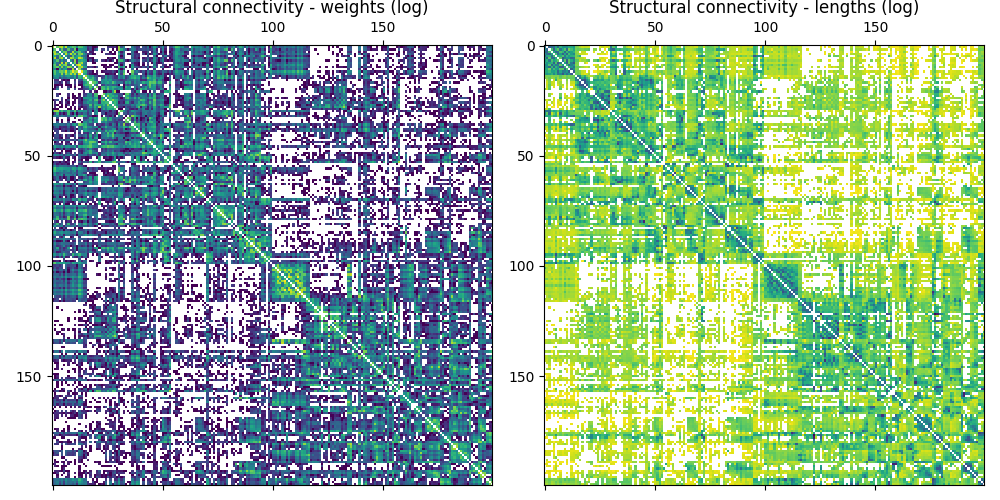

In [17]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

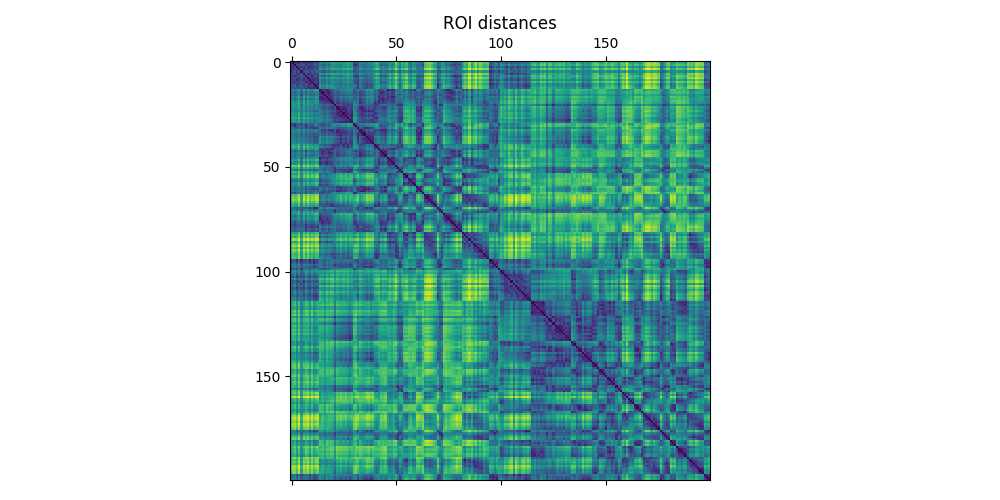

In [18]:
ED = data.schaefer_roi_distances(200)

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [19]:
# from nilearn import plotting
# 
# df = pd.read_csv('../data/external/pytepfit/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
# centroids = np.zeros((len(data_pytepfit['labels']),3))
# centroids[:,0] = df.R
# centroids[:,1] = df.A
# centroids[:,2] = df.S

In [20]:
# dist_to_stim = np.zeros(ED.shape)
# dist_to_stim[:,:] = np.nan
# dist_to_stim[stim_locatin] = SC_W[stim_locatin] # + 1 # +1 tam je, aby se odlišila 0 a nan; pro SC_L ukáže, v čem by mohl být problém
# 
# view = plotting.view_connectome(dist_to_stim, centroids,linewidth=4.0,edge_cmap='jet',symmetric_cmap=False,node_color='lightgray')
# plt.rcParams['figure.figsize'] = [15, 15]
# view.resize(1200,800)
# view # proč k některým vrcholům nevedou čáry? - viz výše, zmatení 0 a nan, vyřeší +1

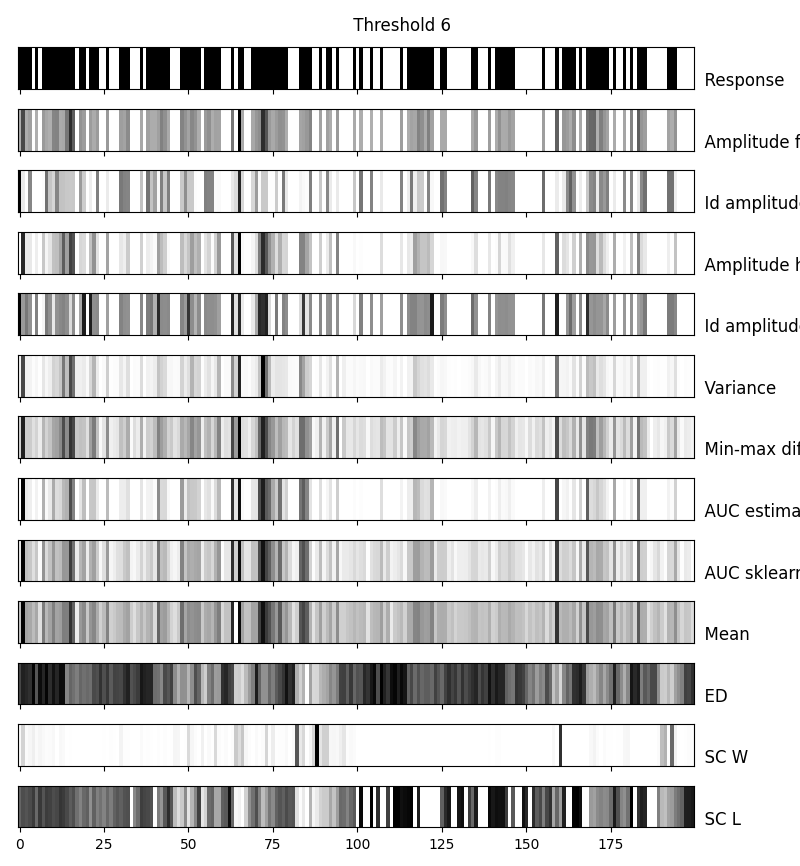

In [21]:
thr = list(responses.keys())[1]

fig, axs = prepare_barcode(13,200, title = f" Threshold {thr}")

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude first")
plot_one_barcode(axs[2],responses[thr]['amp_first_id'],title=f"Id amplitude first")
plot_one_barcode(axs[3],responses[thr]['amp_highest'],title=f"Amplitude highest")
plot_one_barcode(axs[4],responses[thr]['amp_highest_id'],title=f"Id amplitude highest")
plot_one_barcode(axs[5],responses[thr]['variance'],title=f"Variance")
plot_one_barcode(axs[6],responses[thr]['diff'],title=f"Min-max difference ")
plot_one_barcode(axs[7],responses[thr]['AUC_estimate'],title=f"AUC estimate")
plot_one_barcode(axs[8],responses[thr]['AUC_sklearn'],title=f"AUC sklearn")
plot_one_barcode(axs[9],responses[thr]['mean'],title=f"Mean")
plot_one_barcode(axs[10],ED[stim_locatin],title=f"ED")
plot_one_barcode(axs[11],SC_W[stim_locatin],title=f"SC W")
plot_one_barcode(axs[12],SC_L[stim_locatin],title=f"SC L")

## Odfiltruji moc blízké ROI

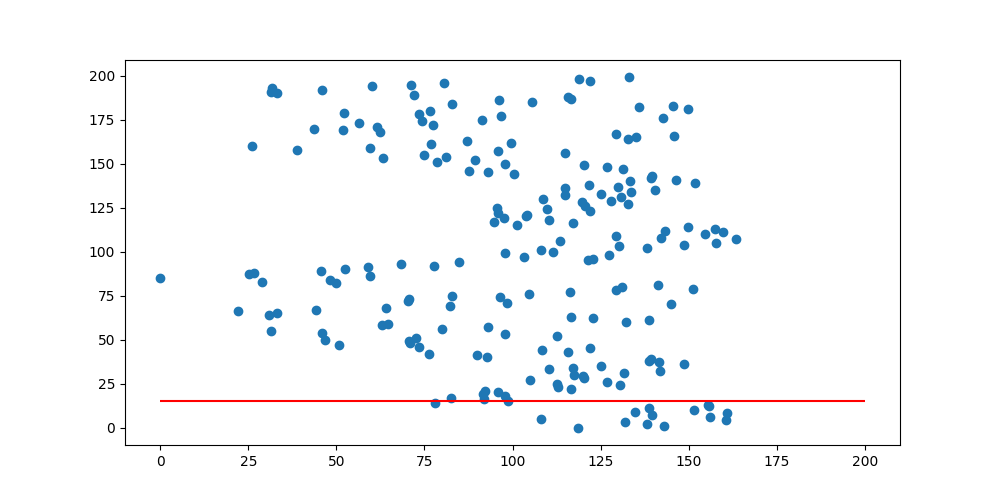

In [22]:
filter_dist = 15
distances = list(ED[stim_locatin])
below_threshold = np.argwhere(ED[stim_locatin] < filter_dist).flatten()

plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.scatter(distances,[i for i in range(len(distances))])
plt.hlines(filter_dist,0,len(distances),'r')
plt.show()

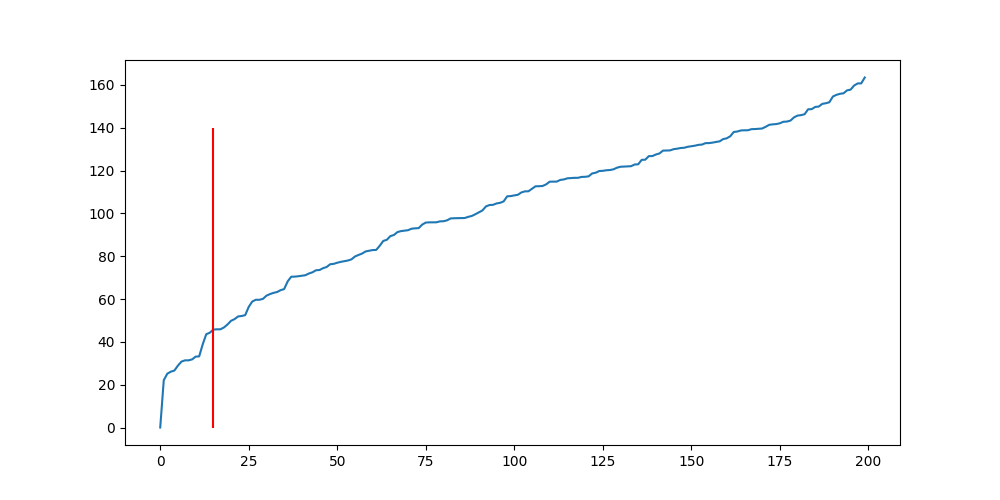

In [23]:
distances.sort()
plt.figure()
plt.plot(distances)
plt.vlines(filter_dist,0,140,colors='r')
plt.show()


In [24]:
# node_colors = ['lightgrey'] * 200
# 
# for n in below_threshold:
#     node_colors[n] = 'black'
# 
# dist_to_stim = np.zeros(ED.shape)
# dist_to_stim[:,:] = np.nan
# dist_to_stim[stim_locatin] = ED[stim_locatin] # + 1 # +1 tam je, aby se odlišila 0 a nan; pro SC_L ukáže, v čem by mohl být problém
# 
# view = plotting.view_connectome(dist_to_stim, centroids,linewidth=4.0,edge_cmap='jet',symmetric_cmap=False,node_color=node_colors,node_size=5.0)
# plt.rcParams['figure.figsize'] = [15, 15]
# view.resize(1200,800)
# view # proč k některým vrcholům nevedou čáry? - viz výše, zmatení 0 a nan, vyřeší +1

## Correlations

In [25]:
PLOT=False

In [26]:
print(spearmanr(SC_W.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_L.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_L.flatten(),nan_policy='omit'))

SignificanceResult(statistic=-0.4212927368010665, pvalue=0.0)
SignificanceResult(statistic=0.7049380439404286, pvalue=0.0)
SignificanceResult(statistic=-0.5897822038378862, pvalue=0.0)


In [27]:
# shortcut for correlation of X with response probability and amplitude 
def coor_with_response(X):
    s = pd.Series(X[stim_locatin])
    # for b in below_threshold:
    #     s[b] = None

    for threshold in thr_range:
        print(f"------------- THRESHOLD {threshold} -------------")
        response_df = responses[threshold]

        stat = pd.DataFrame(index=response_df.keys())
        
        stat['r'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[0])
        stat['p'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[1])
        stat['sigf'] = np.where(stat['p']<0.05,'*','-')

        stat['n_val'] = response_df.count(axis=0)
        print(stat)


# p-val https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

In [28]:
coor_with_response(ED)

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.011067  0.876396    -    200
amp_highest    -0.194813  0.013865    *    159
amp_first      -0.211206  0.007531    *    159
amp_first_id   -0.010299  0.897485    -    159
amp_highest_id -0.127603  0.108963    -    159
variance       -0.148338  0.036057    *    200
variance_ot    -0.200079  0.011991    *    157
diff           -0.130659  0.065165    -    200
diff_ot        -0.190337  0.016953    *    157
AUC_estimate   -0.237826  0.002539    *    159
AUC_sklearn    -0.147852  0.036677    *    200
mean           -0.130802  0.064868    -    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response    -0.086013  0.225885    -    200
amp_highest    -0.156494  0.097869    -    113
amp_first      -0.158278  0.094055    -    113
amp_first_id    0.086282  0.363517    -    113
amp_highest_id -0.033775  0.722484    -    113
variance       -0.148338  0

In [29]:
coor_with_response(SC_W) 

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.027715  0.696861    -    200
amp_highest     0.234337  0.002948    *    159
amp_first       0.134083  0.091988    -    159
amp_first_id   -0.155510  0.050305    -    159
amp_highest_id -0.018865  0.813418    -    159
variance        0.219379  0.001801    *    200
variance_ot     0.271768  0.000575    *    157
diff            0.202784  0.003979    *    200
diff_ot         0.252813  0.001401    *    157
AUC_estimate    0.243444  0.001987    *    159
AUC_sklearn     0.147373  0.037298    *    200
mean            0.128632  0.069480    -    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.153820  0.029656    *    200
amp_highest     0.151999  0.108020    -    113
amp_first      -0.030391  0.749318    -    113
amp_first_id   -0.123508  0.192471    -    113
amp_highest_id -0.033348  0.725855    -    113
variance        0.219379  0

In [30]:
coor_with_response(SC_L) 

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.080481  0.304138    -    200
amp_highest    -0.225911  0.008674    *    159
amp_first      -0.140548  0.105282    -    159
amp_first_id    0.108514  0.212009    -    159
amp_highest_id -0.090883  0.296321    -    159
variance       -0.162245  0.037339    *    200
variance_ot    -0.266320  0.002024    *    157
diff           -0.136604  0.080190    -    200
diff_ot        -0.233777  0.006979    *    157
AUC_estimate   -0.290590  0.000659    *    159
AUC_sklearn    -0.145350  0.062495    -    200
mean           -0.116290  0.136890    -    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response    -0.014843  0.849914    -    200
amp_highest    -0.249959  0.011704    *    113
amp_first      -0.143506  0.152233    -    113
amp_first_id    0.177383  0.075965    -    113
amp_highest_id -0.080933  0.421072    -    113
variance       -0.162245  0

                       r         p sigf  n_val
01-response    -0.106559  0.173119    -    200
amp_highest    -0.343270  0.063288    -     33
amp_first      -0.353059  0.055651    -     33
amp_first_id    0.109820  0.563464    -     33
amp_highest_id -0.140403  0.459289    -     33
variance       -0.162245  0.037339    *    200
variance_ot    -0.402892  0.027281    *     33
diff           -0.136604  0.080190    -    200
diff_ot        -0.364182  0.047874    *     33
AUC_estimate   -0.398888  0.028999    *     33
AUC_sklearn    -0.145350  0.062495    -    200
mean           -0.116290  0.136890    -    200
------------- THRESHOLD 16 -------------
                       r         p sigf  n_val
01-response    -0.205124  0.008218    *    200
amp_highest     0.077357  0.732221    -     24
amp_first       0.134952  0.549318    -     24
amp_first_id   -0.090110  0.690044    -     24
amp_highest_id -0.170182  0.448943    -     24
variance       -0.162245  0.037339    *    200
variance_ot    -0.0

In [31]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

coor_with_response(shorest_path_eff)

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.004954  0.944496    -    200
amp_highest     0.305042  0.000092    *    159
amp_first       0.222283  0.004861    *    159
amp_first_id   -0.112063  0.159621    -    159
amp_highest_id  0.039997  0.616678    -    159
variance        0.260194  0.000198    *    200
variance_ot     0.336228  0.000017    *    157
diff            0.239466  0.000637    *    200
diff_ot         0.316846  0.000053    *    157
AUC_estimate    0.334798  0.000016    *    159
AUC_sklearn     0.211010  0.002706    *    200
mean            0.185205  0.008651    *    200
------------- THRESHOLD 6 -------------


/tmp/ipykernel_86744/427274674.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


                       r         p sigf  n_val
01-response     0.151787  0.031906    *    200
amp_highest     0.262792  0.004923    *    113
amp_first       0.188585  0.045458    *    113
amp_first_id   -0.151910  0.108229    -    113
amp_highest_id  0.031972  0.736737    -    113
variance        0.260194  0.000198    *    200
variance_ot     0.298527  0.001388    *    112
diff            0.239466  0.000637    *    200
diff_ot         0.283066  0.002493    *    112
AUC_estimate    0.267050  0.004245    *    113
AUC_sklearn     0.211010  0.002706    *    200
mean            0.185205  0.008651    *    200
------------- THRESHOLD 8 -------------
                       r         p sigf  n_val
01-response     0.180878  0.010373    *    200
amp_highest     0.246173  0.021537    *     87
amp_first       0.045819  0.673454    -     87
amp_first_id   -0.203355  0.058876    -     87
amp_highest_id  0.098773  0.362721    -     87
variance        0.260194  0.000198    *    200
variance_ot     0.28

In [32]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com)

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.063769  0.369673    -    200
amp_highest     0.243820  0.001954    *    159
amp_first       0.157852  0.046900    *    159
amp_first_id   -0.159457  0.044677    *    159
amp_highest_id -0.014383  0.857200    -    159
variance        0.239229  0.000646    *    200
variance_ot     0.275975  0.000468    *    157
diff            0.224493  0.001394    *    200
diff_ot         0.261919  0.000921    *    157
AUC_estimate    0.247898  0.001630    *    159
AUC_sklearn     0.171928  0.014919    *    200
mean            0.150365  0.033565    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.168711  0.016935    *    200
amp_highest     0.156356  0.098169    -    113
amp_first       0.023205  0.807259    -    113
amp_first_id   -0.118842  0.209949    -    113
amp_highest_id -0.031552  0.740075    -    113
variance        0.239229  0

In [33]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

coor_with_response(SI)

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))


------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response    -0.031457  0.659163    -    200
amp_highest    -0.247341  0.001729    *    159
amp_first      -0.146544  0.066161    -    159
amp_first_id    0.169924  0.032801    *    159
amp_highest_id  0.032435  0.685790    -    159
variance       -0.230432  0.001059    *    200
variance_ot    -0.285662  0.000301    *    157
diff           -0.213506  0.002463    *    200
diff_ot        -0.266198  0.000783    *    157
AUC_estimate   -0.260053  0.000967    *    159
AUC_sklearn    -0.159265  0.024646    *    200
mean           -0.140228  0.048214    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response    -0.161004  0.023100    *    200
amp_highest    -0.166783  0.078816    -    113
amp_first       0.024588  0.796920    -    113
amp_first_id    0.147197  0.121439    -    113
amp_highest_id  0.054371  0.569099    -    113
variance       -0.230432  0

In [34]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

coor_with_response(diffusion)

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.046693  0.511461    -    200
amp_highest    -0.080389  0.313792    -    159
amp_first      -0.167238  0.035116    *    159
amp_first_id   -0.042389  0.595747    -    159
amp_highest_id  0.012517  0.875562    -    159
variance       -0.026002  0.714756    -    200
variance_ot    -0.073245  0.361952    -    157
diff           -0.016221  0.819660    -    200
diff_ot        -0.057613  0.473548    -    157
AUC_estimate   -0.115118  0.148475    -    159
AUC_sklearn    -0.060036  0.398403    -    200
mean           -0.051064  0.472696    -    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.004362  0.951122    -    200
amp_highest    -0.102011  0.282310    -    113
amp_first      -0.126090  0.183266    -    113
amp_first_id    0.175030  0.063704    -    113
amp_highest_id  0.003601  0.969808    -    113
variance       -0.026002  0

In [35]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff)

/tmp/ipykernel_86744/3727610595.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.106340  0.133952    -    200
amp_highest     0.193947  0.014302    *    159
amp_first       0.106146  0.182974    -    159
amp_first_id   -0.248588  0.001580    *    159
amp_highest_id -0.052229  0.513217    -    159
variance        0.200263  0.004465    *    200
variance_ot     0.181582  0.022847    *    157
diff            0.203055  0.003930    *    200
diff_ot         0.179671  0.024346    *    157
AUC_estimate    0.212375  0.007198    *    159
AUC_sklearn     0.200830  0.004352    *    200
mean            0.197001  0.005174    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.217614  0.001965    *    200
amp_highest     0.047737  0.615600    -    113
amp_first      -0.048797  0.607773    -    113
amp_first_id   -0.078897  0.406167    -    113
amp_highest_id -0.025028  0.792445    -    113
variance        0.200263  0

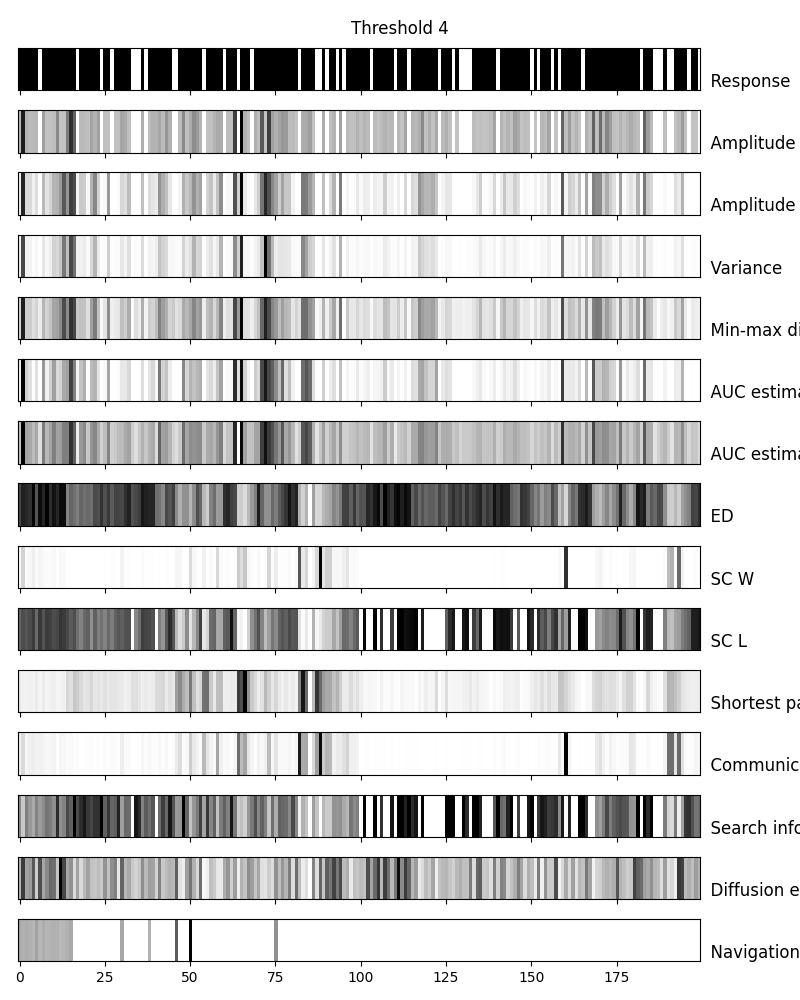

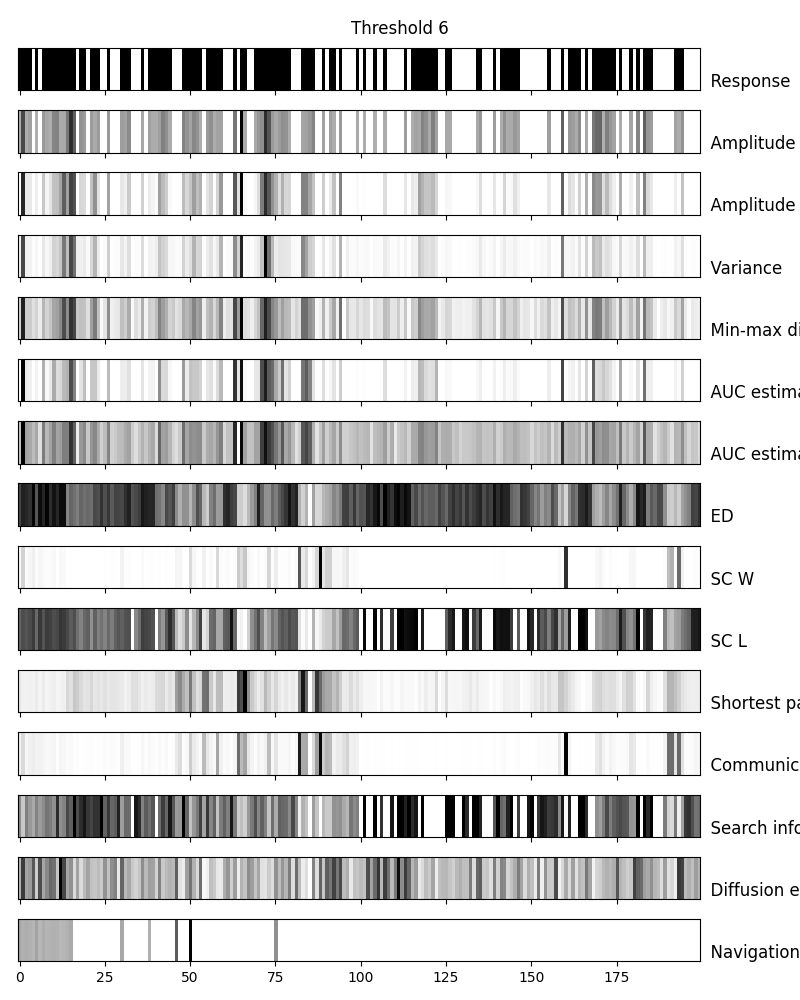

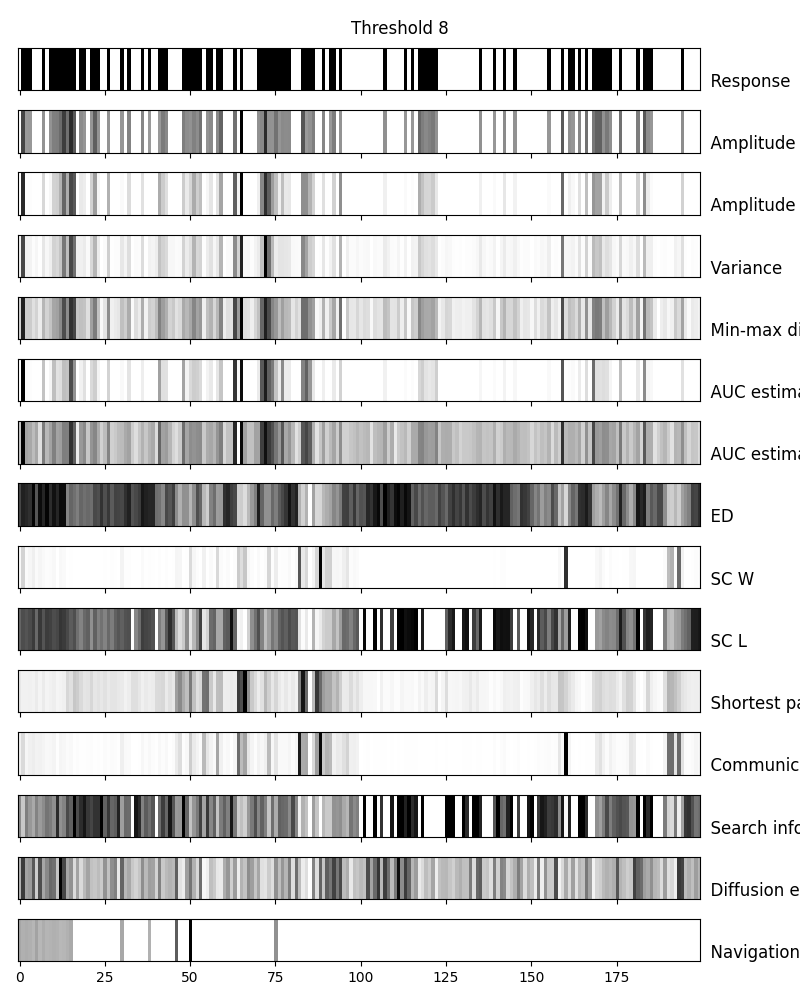

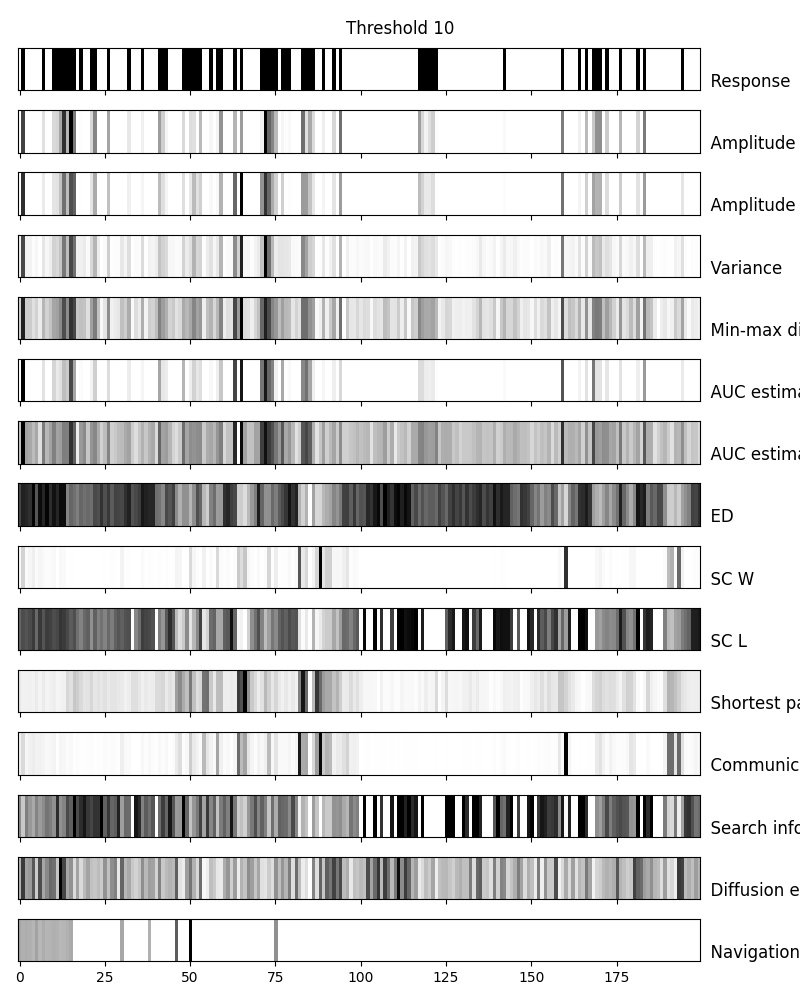

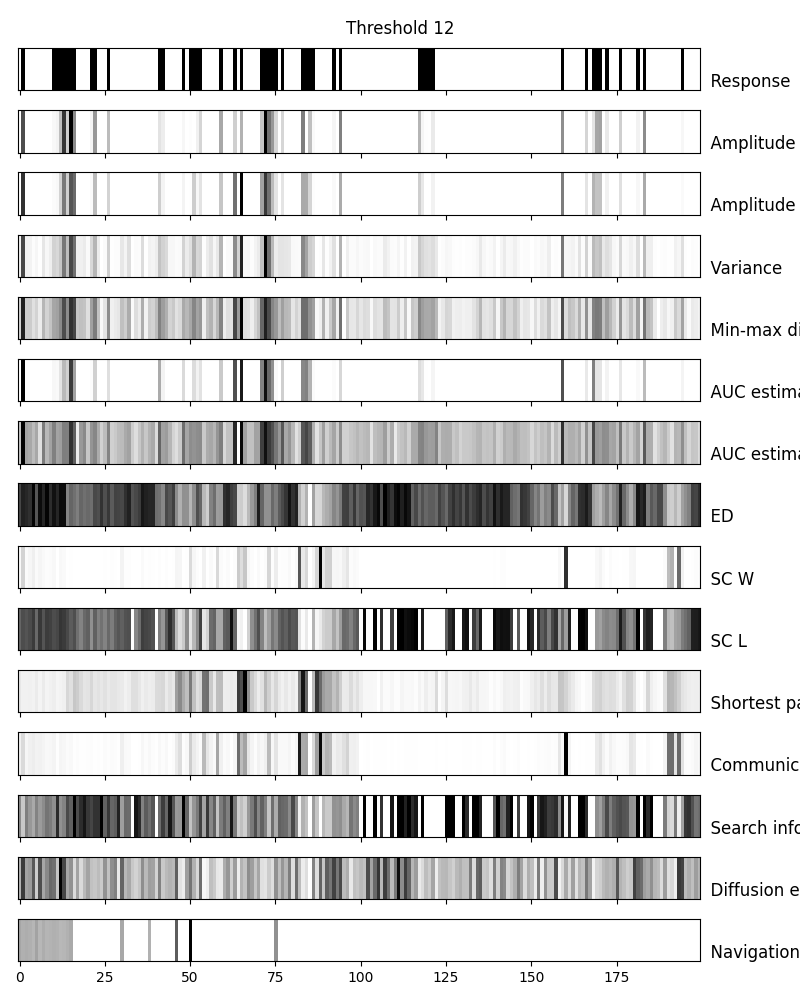

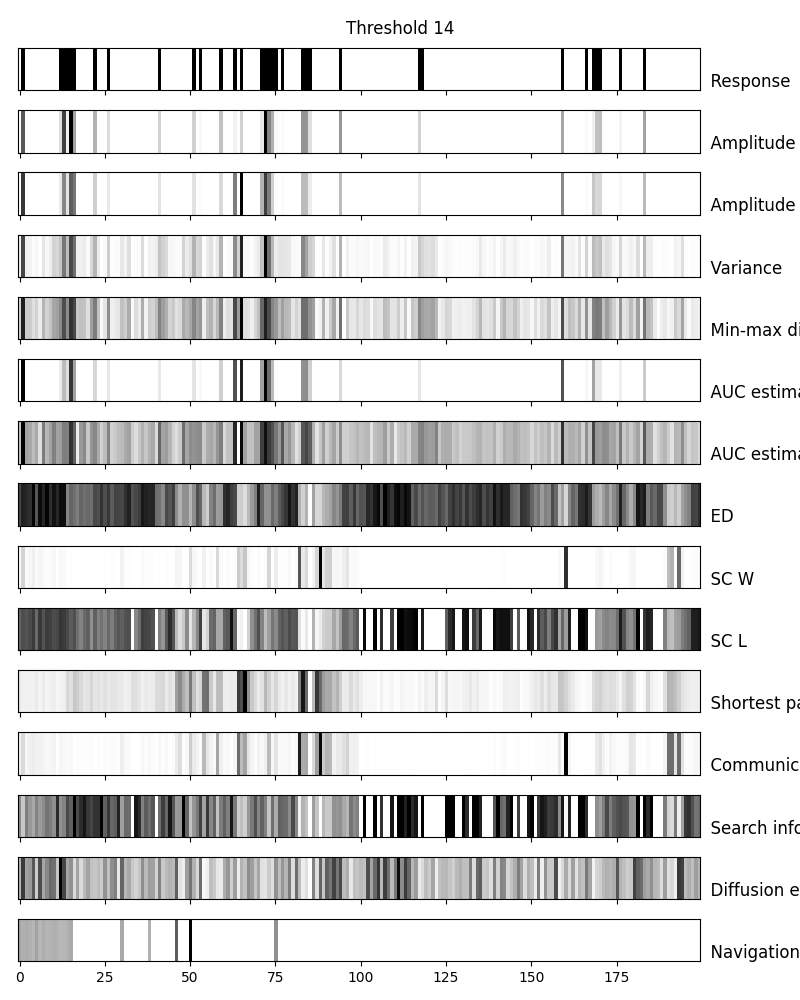

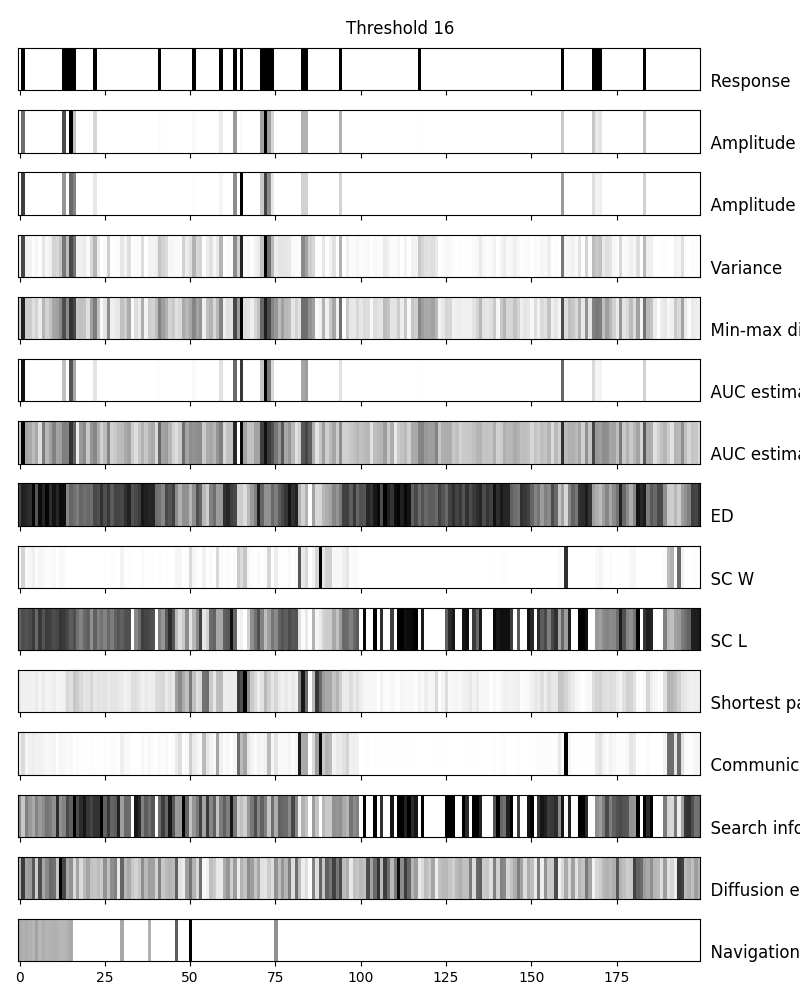

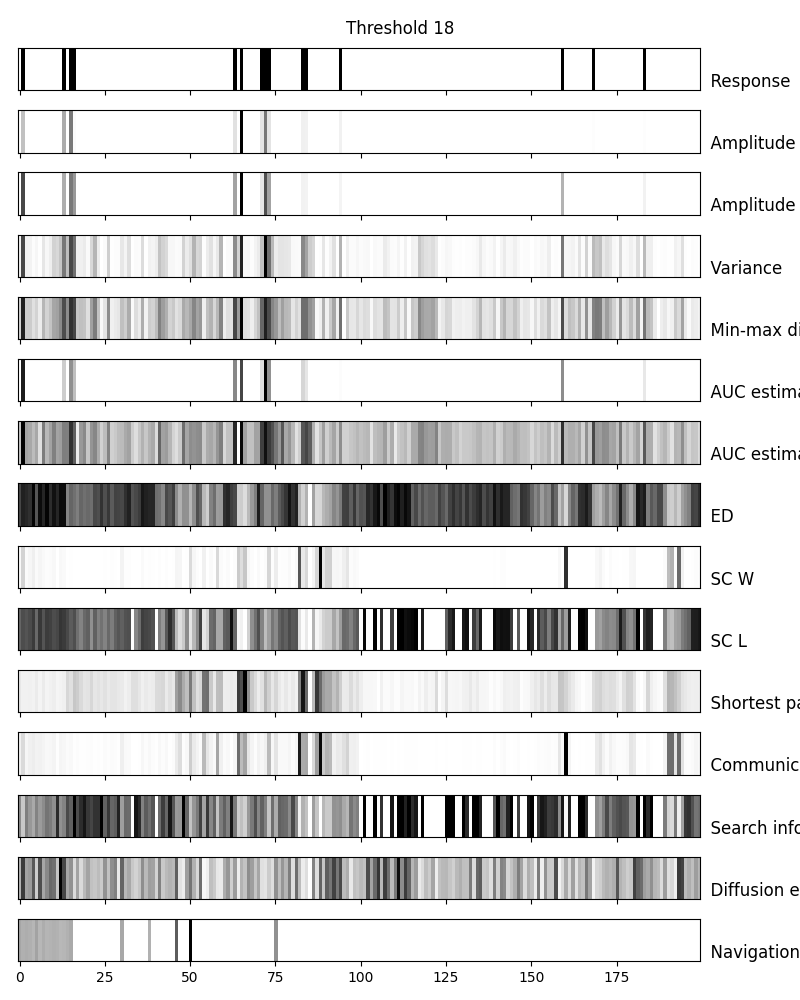

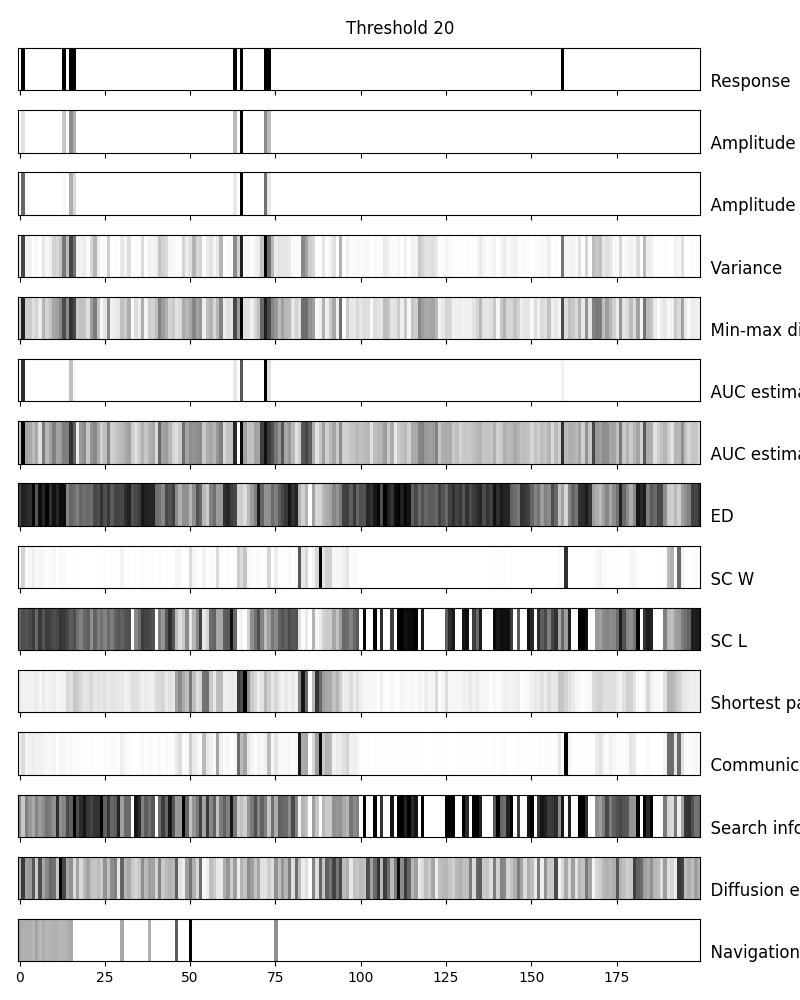

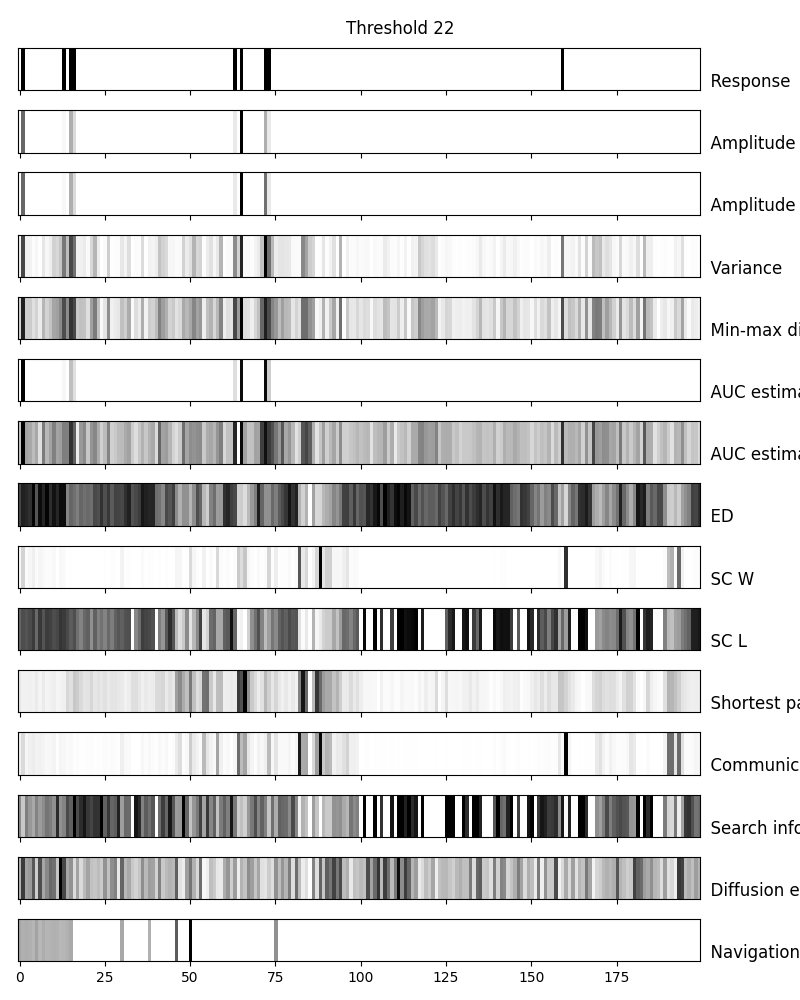

In [36]:
for thr in list(responses.keys()):
    fig, axs = prepare_barcode(15,200, title=f"Threshold {thr}")

    plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
    plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude")
    plot_one_barcode(axs[2],responses[thr]['amp_highest'],title=f"Amplitude highest")
    plot_one_barcode(axs[3],responses[thr]['variance'],title=f"Variance")
    plot_one_barcode(axs[4],responses[thr]['diff'],title=f"Min-max diff")
    plot_one_barcode(axs[5],responses[thr]['AUC_estimate'],title=f"AUC estimate")
    plot_one_barcode(axs[6],responses[thr]['mean'],title=f"AUC estimate")
    plot_one_barcode(axs[7],ED[stim_locatin],title=f"ED")
    plot_one_barcode(axs[8],SC_W[stim_locatin],title=f"SC W")
    plot_one_barcode(axs[9],SC_L[stim_locatin],title=f"SC L")
    plot_one_barcode(axs[10],shorest_path_eff[stim_locatin],title=f"Shortest path")
    plot_one_barcode(axs[11],com[stim_locatin],title=f"Communicability")
    plot_one_barcode(axs[12],SI[stim_locatin],title=f"Search information")
    plot_one_barcode(axs[13],diffusion[stim_locatin],title=f"Diffusion eff.")
    plot_one_barcode(axs[14],nav_eff[stim_locatin],title=f"Navigation eff.")